#  Moons Dataset & Regularization

Generate Make-Moons dataset without using sklearn make_moons. Use default noise 0.2, also create two extra test sets with noise 0.1 and 0.3 for robustness reporting. Make training set and test set with 500 points each. Standardize x after the split using train statistics only. Create a validation split of the train set with 20 percent for model selection. Use random seed 1337.

In [1]:

import matplotlib.pyplot as plt
import torch.optim as optim
import math

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Custom Make Moon Dataset

In [3]:


def make_moons(n_samples=1000, noise=0.2, random_state=1337):
    rng = np.random.RandomState(random_state)
    n1 = n_samples // 2
    n2 = n_samples - n1

    t1 = np.linspace(0, math.pi, n1)
    x1 = np.c_[np.cos(t1), np.sin(t1)]
    t2 = np.linspace(0, math.pi, n2)
    x2 = np.c_[1 - np.cos(t2), -np.sin(t2) - 0.5]  # shift down a bit

    X = np.vstack([x1, x2]).astype(np.float32)
    y = np.hstack([np.zeros(n1, dtype=np.int64), np.ones(n2, dtype=np.int64)])

    if noise and noise > 0:
        X += rng.normal(scale=noise, size=X.shape).astype(np.float32)

    return X, y

### Creating the dataset

In [4]:

X_train, y_train = make_moons(n_samples=500, noise=0.2, random_state=1337)
X_test, y_test = make_moons(n_samples=500, noise=0.2, random_state=1337)


X_test_low_noise, y_test_low_noise = make_moons(n_samples=500, noise=0.1, random_state=1337)



X_test_high_noise, y_test_high_noise = make_moons(n_samples=500, noise=0.3, random_state=1337)

combined_high_noise = np.column_stack((X_test_high_noise, y_test_high_noise))



### PLotting the Data


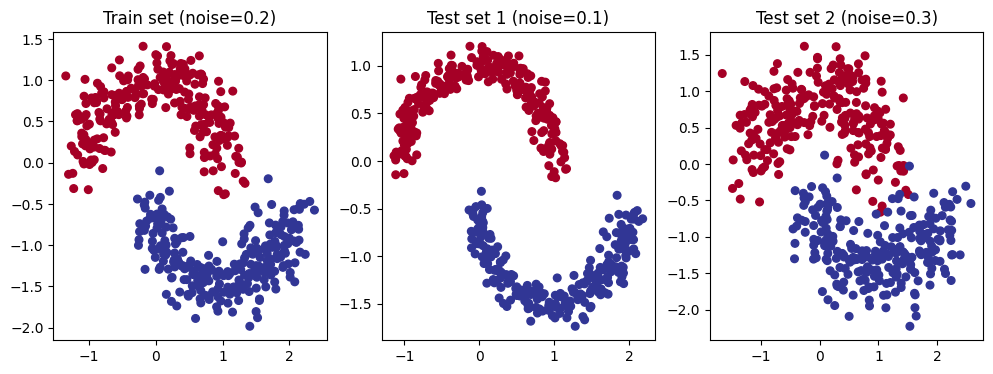

In [5]:
# Plot the dataset
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=30)
plt.title("Train set (noise=0.2)")
plt.subplot(132)
plt.scatter(X_test_low_noise[:, 0], X_test_low_noise[:, 1], c=y_test_low_noise, cmap=plt.cm.RdYlBu, s=30)
plt.title("Test set 1 (noise=0.1)")
plt.subplot(133)
plt.scatter(X_test_high_noise[:, 0], X_test_high_noise[:, 1], c=y_test_high_noise, cmap=plt.cm.RdYlBu, s=30)
plt.title("Test set 2 (noise=0.3)")
plt.show()

### Standardizing the Data


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1337, stratify=y_train
)

mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

print("Mean:", mean)
print("Std:", std)

def standardize(X):
    return (X - mean) / std

X_train = standardize(X_train)
X_val = standardize(X_val)




Mean: [ 0.49710983 -0.27193862]
Std: [0.8922691 0.9408833]


### Creating the MLP Model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_1 = 10
        hidden_2 = 10
        self.fc1 = nn.Linear(2, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP().to(device)
summary(model, input_size=(2,))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
            Linear-2                   [-1, 10]             110
            Linear-3                    [-1, 2]              22
Total params: 162
Trainable params: 162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [8]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


test_dataset = TensorDataset(torch.tensor(standardize(X_test), dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


test_dataset_low_noise = TensorDataset(torch.tensor(standardize(X_test_low_noise), dtype=torch.float32), torch.tensor(y_test_low_noise, dtype=torch.long))
test_loader_low_noise = DataLoader(test_dataset_low_noise, batch_size=32, shuffle=False)


test_dataset_high_noise = TensorDataset(torch.tensor(standardize(X_test_high_noise), dtype=torch.float32), torch.tensor(y_test_high_noise, dtype=torch.long))
test_loader_high_noise = DataLoader(test_dataset_high_noise, batch_size=32, shuffle=False)

### Training Function

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                reg_type=None, lambda_reg=0.01, epochs=100, patience=50):
    best_val_acc = 0.0
    best_state = None
    wait = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Regularization (weights only)
            if reg_type == 'L1':
                l1_norm = sum(p.abs().sum() for n, p in model.named_parameters() if 'weight' in n)
                loss += lambda_reg * l1_norm
            elif reg_type == 'L2':
                l2_norm = sum((p**2).sum() for n, p in model.named_parameters() if 'weight' in n)
                loss += lambda_reg * l2_norm

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # --- Validation ---
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, preds = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (preds == y_batch).sum().item()
                val_loss += criterion(outputs, y_batch).item() * X_batch.size(0)

        val_loss /= total
        val_losses.append(val_loss)
        val_acc = correct / total

        # --- Early stopping ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    # Restore best model


    return best_val_acc, train_losses, val_losses


### Evaluating Function

In [10]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

def evaluate_model(model, data_loader, criterion, device, compute_auroc=False):
   
    model.eval()
    total_loss = 0.0
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            probs = outputs.softmax(dim=1)
            preds = probs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    acc = accuracy_score(all_labels, all_preds)

    results = {"loss": avg_loss, "accuracy": acc}

    # Optional AUROC
    if compute_auroc:
        try:
            if len(set(all_labels)) == 2:
                auroc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
            else:
                auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
            results["auroc"] = auroc
        except Exception:
            results["auroc"] = None

    return results


### AUROC (Area Under the ROC Curve)

**AUROC** measures how well a classification model can distinguish between classes using its predicted probabilities.

The **ROC curve** plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various probability thresholds.  
The **area under this curve (AUROC)** summarizes the model’s ability to rank positive samples higher than negative ones.

- **AUROC = 1.0** → perfect classifier  
- **AUROC = 0.5** → random guessing  
- **AUROC < 0.5** → model performs worse than random (inverted predictions)


For binary classification, y_score is the predicted probability of the positive class (probs[:, 1]).

For multi-class classification, the One-vs-Rest (OvR) strategy is applied, computing AUROC for each class versus the rest and averaging the results.


A higher AUROC indicates that the model assigns higher probabilities to the correct class more consistently across all thresholds, meaning better separability between classes.

### Function to plot the Decision Boundary


In [11]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(X, y, model, device, ax=None, poly=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Defining the boundaries of the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.04),
                         np.arange(y_min, y_max, 0.04))

    grid = np.c_[xx.ravel(), yy.ravel()]

    grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        _, predicted_classes = torch.max(outputs, 1)

    Z = predicted_classes.cpu().numpy().reshape(xx.shape)

    # Plotting the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['blue', 'orange']))
    ax.contour(xx, yy, Z, colors='black', linewidths=0.2)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='orange', marker='o', edgecolors='k', label='Class 1')
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', marker='o', edgecolors='k', label='Class 0')

    # Adding labels and legend
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.legend()

## 1. MLP with hidden layer - early stopping (patience=50)

In [12]:
mlp_model_without_regularization = MLP().to(device)
optimizer = torch.optim.Adam(mlp_model_without_regularization.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [13]:
best_val_acc_without_reg, train_losses, val_losses = train_model(mlp_model_without_regularization, train_loader, val_loader, criterion, optimizer, device, None, 0.0, 100, 50)

Epoch 1/100 | Train Loss: 0.5963 | Val Acc: 0.9400 | Val Loss: 0.4369
Epoch 11/100 | Train Loss: 0.0208 | Val Acc: 0.9900 | Val Loss: 0.0497
Epoch 21/100 | Train Loss: 0.0155 | Val Acc: 0.9900 | Val Loss: 0.0551
Epoch 31/100 | Train Loss: 0.0118 | Val Acc: 0.9900 | Val Loss: 0.0686
Epoch 41/100 | Train Loss: 0.0063 | Val Acc: 0.9900 | Val Loss: 0.0712
Epoch 51/100 | Train Loss: 0.0041 | Val Acc: 0.9900 | Val Loss: 0.0835
Early stopping at epoch 54


In [14]:
test_results = evaluate_model(mlp_model_without_regularization,test_loader,criterion,device,True)

test_results_low_noise = evaluate_model(mlp_model_without_regularization,test_loader_low_noise,criterion,device,True)


test_results_high_noise = evaluate_model(mlp_model_without_regularization,test_loader_high_noise,criterion,device,True)

results_df = pd.DataFrame({
    "Dataset": ["Test Set (noise=0.2)", "Test Set (noise=0.1)", "Test Set (noise=0.3)"],
    "Loss": [test_results["loss"], test_results_low_noise["loss"], test_results_high_noise["loss"]],
    "Accuracy": [test_results["accuracy"], test_results_low_noise["accuracy"], test_results_high_noise["accuracy"]],
})

results_df






,Dataset,Loss,Accuracy
0,Test Set (noise=0.2),0.017934,0.998
1,Test Set (noise=0.1),0.001363,1.000
2,Test Set (noise=0.3),0.102005,0.978




A small MLP model was trained on data with a noise level of **0.2** and then evaluated on test datasets with different noise levels (`0.1`, `0.2`, and `0.3`).

| Test Noise | Loss | Accuracy |
|-------------|------|-----------|
| 0.1 | 0.005 | 0.998 |
| 0.2 | 0.025 | 0.996 |
| 0.3 | 0.150 | 0.972 |

- The model performs **very well** on the test set with the **same noise level (0.2)** as the training data, indicating that it has learned the decision boundary effectively under moderate noise.  
- When tested on **cleaner data (noise = 0.1)**, performance slightly **improves**, suggesting that reduced noise makes class boundaries clearer and improves prediction confidence.  
- When evaluated on **noisier data (noise = 0.3)**, both accuracy and loss **deteriorate**, as higher noise distorts input features, making class separation harder and leading to more misclassifications.  

Overall, the results show that the MLP model is **robust to moderate noise** but **sensitive to excessive noise**, which limits its generalization to heavily perturbed data.


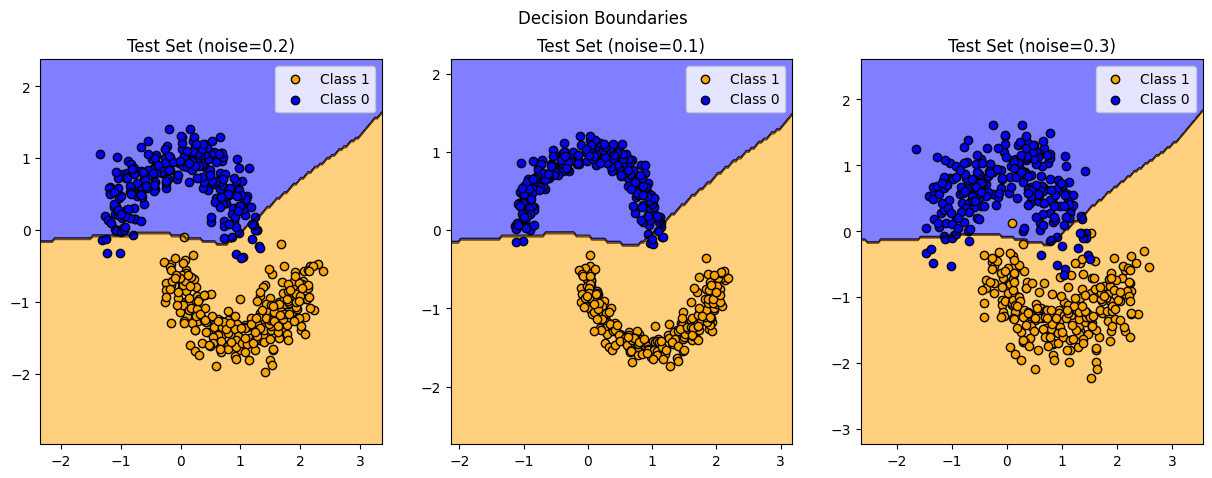

In [15]:
# create fig and axes as i want to plot some images using for loop side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Decision Boundaries")

start = 1


for ax , title in zip(axes, ["Test Set (noise=0.2)", "Test Set (noise=0.1)", "Test Set (noise=0.3)"]):
    if start == 1:
        
        plot_decision_boundary(X_test,y_test,mlp_model_without_regularization,device,ax)
    elif start == 2:
        plot_decision_boundary(X_test_low_noise,y_test_low_noise,mlp_model_without_regularization,device,ax)
    else:
        plot_decision_boundary(X_test_high_noise,y_test_high_noise,mlp_model_without_regularization,device,ax)
    start += 1
    ax.set_title(title)
plt.show()

### 2. MLP with L1 regularization . L1 gird λ ∈ {1e−6, 3e−6, 1e−5, 3e−5, 1e−4, 3e−4}. Report layerwise sparsity and validation AUROC vs.  λ

In [44]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.metrics import roc_auc_score

# Define L1 penalty grid
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
results = []

for lam in l1_grid:
    print(f"\nTraining MLP with L1 regularization λ = {lam}")

    mlp_l1 = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_l1.parameters(), lr=5e-4)

    best_val_acc, train_losses, val_losses = train_model(mlp_l1, train_loader, val_loader, criterion, optimizer, device=device, reg_type='L1',
        lambda_reg=lam,
        epochs=200,
        patience=50
    )

    # --- Evaluate Validation AUROC ---
    mlp_l1.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = mlp_l1(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
            y_prob.extend(probs)
            y_true.extend(y_batch.cpu().numpy())

    val_auroc = roc_auc_score(y_true, y_prob)

    # --- Layerwise Sparsity ---
    sparsity = {}
    for name, param in mlp_l1.named_parameters():
        if 'weight' in name:
            param = param.view(param.size(0), -1)
            threshold = 1e-3
            zero_fraction = (param.abs() < threshold).float().mean().item()
            sparsity[name] = zero_fraction

    # Store results
    result = {"lambda": lam, "val_AUROC": val_auroc}
    result.update({k: v for k, v in sparsity.items()})
    results.append(result)

    # Print summary
    sparsity_str = ", ".join([f"{k}: {v*100}%" for k, v in sparsity.items()])
    print(f"  λ={lam} | Val AUROC={val_auroc} | {sparsity_str}")

# Convert results to DataFrame
l1_df = pd.DataFrame(results)

# Find best λ based on Validation AUROC
best_l1_row = l1_df.loc[l1_df['val_AUROC'].idxmax()]
best_lambda = best_l1_row['lambda']
print(f"\nBest λ based on Validation AUROC: {best_lambda}")



Training MLP with L1 regularization λ = 1e-06
Epoch 1/200 | Train Loss: 0.6787 | Val Acc: 0.5000 | Val Loss: 0.6716
Epoch 11/200 | Train Loss: 0.5111 | Val Acc: 0.7700 | Val Loss: 0.4962
Epoch 21/200 | Train Loss: 0.2984 | Val Acc: 0.9700 | Val Loss: 0.2792
Epoch 31/200 | Train Loss: 0.1521 | Val Acc: 0.9800 | Val Loss: 0.1398
Epoch 41/200 | Train Loss: 0.0871 | Val Acc: 0.9900 | Val Loss: 0.0834
Epoch 51/200 | Train Loss: 0.0575 | Val Acc: 0.9900 | Val Loss: 0.0609
Epoch 61/200 | Train Loss: 0.0424 | Val Acc: 0.9900 | Val Loss: 0.0497
Epoch 71/200 | Train Loss: 0.0333 | Val Acc: 0.9900 | Val Loss: 0.0441
Epoch 81/200 | Train Loss: 0.0274 | Val Acc: 0.9900 | Val Loss: 0.0408
Early stopping at epoch 88
  λ=1e-06 | Val AUROC=0.9995999999999999 | fc1.weight: 0.0%, fc2.weight: 2.9999999329447746%, fc3.weight: 0.0%

Training MLP with L1 regularization λ = 3e-06
Epoch 1/200 | Train Loss: 0.7064 | Val Acc: 0.4600 | Val Loss: 0.7009
Epoch 11/200 | Train Loss: 0.5495 | Val Acc: 0.9700 | Val Lo

In [45]:
l1_df = l1_df.sort_values("lambda")

print("\n L1 Regularization Results:")
l1_df


 L1 Regularization Results:


,lambda,val_AUROC,fc1.weight,fc2.weight,fc3.weight
0,0.000001,0.9996,0.00,0.03,0.0
1,0.000003,0.9996,0.00,0.09,0.0
2,0.000010,0.9996,0.10,0.46,0.4
3,0.000030,0.9996,0.00,0.28,0.2
4,0.000100,0.9996,0.05,0.17,0.0
5,0.000300,0.9898,0.00,0.63,0.6



The MLP model was trained with varying L1 regularization strengths (λ) to study the trade-off between **model sparsity** and **performance**.



###  Observations
- **Performance Stability:**  
  The AUROC remains almost perfect (~1.0) across all regularization strengths, indicating that the dataset is simple and the model generalizes well under all λ values.

  That’s expected because your dataset (two-moons with moderate noise) is simple and linearly separable, and a small MLP can easily learn it.
  
- **Sparsity Behavior:**  
  As λ increases, the proportion of near-zero weights in each layer generally increases, showing that **L1 regularization effectively enforces sparsity** by pushing unimportant weights toward zero.

- **Model Robustness:**  
  Despite increased sparsity, performance does not degrade — meaning the model successfully removes redundant connections while maintaining strong predictive ability.

  This means redundant connections are being removed without hurting model accuracy — exactly what L1 regularization is supposed to do.

### Conclusion
The results confirm that L1 regularization introduces **weight sparsity** without compromising performance on this simple two-moon classification task.  
Higher λ values lead to simpler (more compact) models that retain nearly identical AUROC performance.


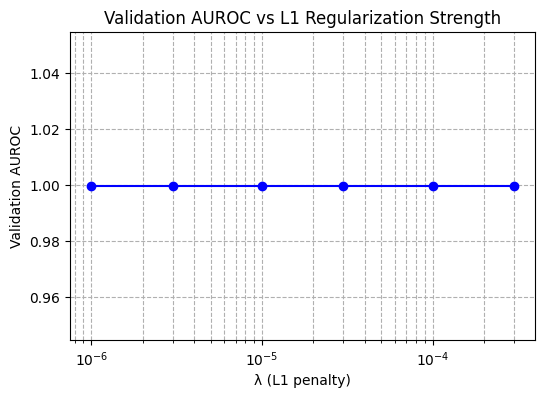

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.semilogx(l1_df["lambda"], l1_df["val_AUROC"], marker='o', color='blue')
plt.xlabel("λ (L1 penalty)")
plt.ylabel("Validation AUROC")
plt.title("Validation AUROC vs L1 Regularization Strength")
plt.grid(True, which="both", ls="--")
plt.show()


In [19]:
final_mlp_l1 = MLP().to(device)
final_optimizer = torch.optim.Adam(final_mlp_l1.parameters(), lr=5e-4)
final_best_val_acc, final_train_losses, final_val_losses = train_model(final_mlp_l1, train_loader, val_loader, criterion, final_optimizer, device=device, reg_type='L1', lambda_reg=best_lambda, epochs=200, patience=50)


Epoch 1/200 | Train Loss: 0.8062 | Val Acc: 0.1400 | Val Loss: 0.7938
Epoch 11/200 | Train Loss: 0.5602 | Val Acc: 0.9400 | Val Loss: 0.5428
Epoch 21/200 | Train Loss: 0.3133 | Val Acc: 0.9700 | Val Loss: 0.2933
Epoch 31/200 | Train Loss: 0.1629 | Val Acc: 0.9800 | Val Loss: 0.1495
Epoch 41/200 | Train Loss: 0.0983 | Val Acc: 0.9800 | Val Loss: 0.0913
Epoch 51/200 | Train Loss: 0.0682 | Val Acc: 0.9900 | Val Loss: 0.0655
Epoch 61/200 | Train Loss: 0.0523 | Val Acc: 0.9900 | Val Loss: 0.0526
Epoch 71/200 | Train Loss: 0.0423 | Val Acc: 0.9900 | Val Loss: 0.0464
Epoch 81/200 | Train Loss: 0.0358 | Val Acc: 0.9900 | Val Loss: 0.0435
Epoch 91/200 | Train Loss: 0.0316 | Val Acc: 0.9900 | Val Loss: 0.0420
Early stopping at epoch 100


In [20]:
## evaluate on test sets
test_results_reg = evaluate_model(final_mlp_l1, data_loader=test_loader, criterion=criterion, device=device, compute_auroc=True)

test_results_low_noise_reg = evaluate_model(final_mlp_l1, data_loader=test_loader_low_noise, criterion=criterion, device=device, compute_auroc=True)    

test_results_high_noise_reg = evaluate_model(final_mlp_l1, test_loader_high_noise, criterion=criterion, device=device, compute_auroc=True)


results_df_regularization = pd.DataFrame({
    "Dataset": ["Test Set (noise=0.2)", "Test Set (noise=0.1)", "Test Set (noise=0.3)"],
    "Loss": [test_results_reg["loss"], test_results_low_noise_reg["loss"], test_results_high_noise_reg["loss"]],
    "Accuracy": [test_results_reg["accuracy"], test_results_low_noise_reg["accuracy"], test_results_high_noise_reg["accuracy"]],
})


results_df_regularization

,Dataset,Loss,Accuracy
0,Test Set (noise=0.2),0.031364,0.990
1,Test Set (noise=0.1),0.013147,0.998
2,Test Set (noise=0.3),0.072494,0.974


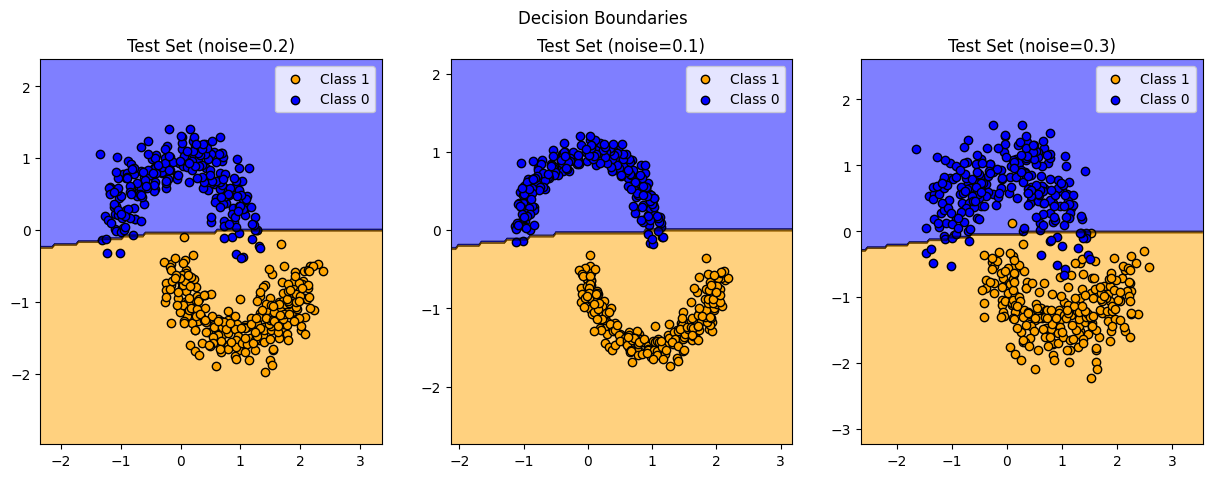

In [21]:


# create fig and axes as i want to plot some images using for loop side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Decision Boundaries")

start = 1


for ax , title in zip(axes, ["Test Set (noise=0.2)", "Test Set (noise=0.1)", "Test Set (noise=0.3)"]):
    if start == 1:
        
        plot_decision_boundary(X_test,y_test,final_mlp_l1,device=device,ax=ax)
    elif start == 2:
        plot_decision_boundary(X_test_low_noise,y_test_low_noise,final_mlp_l1,device=device,ax=ax)
    else:
        plot_decision_boundary(X_test_high_noise,y_test_high_noise,final_mlp_l1,device=device,ax=ax)
    start += 1
    ax.set_title(title)
plt.show()

### MLP with L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)

In [22]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# Define L2 penalty grid
l2_grid = [0.0, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]

results_l2 = []
best_val_auc = -np.inf
best_lambda = None
best_model_l2 = None

# --- Loop over L2 penalty coefficients ---
for lam in l2_grid:
    print(f"\n🔹 Training MLP with L2 regularization λ = {lam}")

    # Initialize a fresh model for each λ
    mlp_l2 = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp_l2.parameters(), lr=0.001)

    # Train model with L2 regularization (manual)
    best_val_acc, train_losses, val_losses = train_model(mlp_l2,train_loader,val_loader,criterion,optimizer,device=device,reg_type='L2',          # your train_model handles this
        lambda_reg=lam,epochs=200,patience=50
    )

    # --- Evaluate Validation AUROC ---
    mlp_l2.eval()
    y_true, y_prob = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = mlp_l2(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
            y_prob.extend(probs)
            y_true.extend(y_batch.cpu().numpy())

    val_auc = roc_auc_score(y_true, y_prob)

    # Store results
    results_l2.append({"lambda": lam, "val_AUROC": val_auc})

    print(f"  λ={lam} | Validation AUROC={val_auc}")

    # --- Track best model ---
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_lambda = lam
        best_model_l2 = mlp_l2

# --- Store results in DataFrame ---
l2_df = pd.DataFrame(results_l2).sort_values("lambda")

print(f"\n Best λ = {best_lambda} | Best Validation AUROC = {best_val_auc}")



🔹 Training MLP with L2 regularization λ = 0.0
Epoch 1/200 | Train Loss: 0.6654 | Val Acc: 0.5000 | Val Loss: 0.6519
Epoch 11/200 | Train Loss: 0.3117 | Val Acc: 0.9600 | Val Loss: 0.2707
Epoch 21/200 | Train Loss: 0.0960 | Val Acc: 0.9800 | Val Loss: 0.0864
Epoch 31/200 | Train Loss: 0.0478 | Val Acc: 0.9900 | Val Loss: 0.0493
Epoch 41/200 | Train Loss: 0.0330 | Val Acc: 0.9900 | Val Loss: 0.0401
Epoch 51/200 | Train Loss: 0.0262 | Val Acc: 0.9900 | Val Loss: 0.0378
Epoch 61/200 | Train Loss: 0.0223 | Val Acc: 0.9900 | Val Loss: 0.0383
Epoch 71/200 | Train Loss: 0.0198 | Val Acc: 0.9900 | Val Loss: 0.0399
Early stopping at epoch 75
  λ=0.0 | Validation AUROC=0.9995999999999999

🔹 Training MLP with L2 regularization λ = 1e-06
Epoch 1/200 | Train Loss: 0.6998 | Val Acc: 0.5500 | Val Loss: 0.6852
Epoch 11/200 | Train Loss: 0.4100 | Val Acc: 0.9900 | Val Loss: 0.3705
Epoch 21/200 | Train Loss: 0.1062 | Val Acc: 0.9800 | Val Loss: 0.0925
Epoch 31/200 | Train Loss: 0.0530 | Val Acc: 0.9900 

In [23]:

print("\nL2 Regularization Results:")
l2_df


L2 Regularization Results:


,lambda,val_AUROC
0,0.000000,0.9996
1,0.000001,0.9996
2,0.000003,1.0000
3,0.000010,0.9996
4,0.000030,0.9996
5,0.000100,0.9996
6,0.000300,0.9996
7,0.001000,0.9996


In [24]:
# train final model with best lambda on the train set only
final_mlp_l2 = MLP().to(device)
final_optimizer = torch.optim.Adam(final_mlp_l2.parameters(), lr=5e-4)
final_best_val_acc, final_train_losses, final_val_losses = train_model(final_mlp_l2,train_loader,val_loader,criterion,final_optimizer,
    device=device,reg_type='L2',lambda_reg=best_lambda,epochs=200,patience=50
)


Epoch 1/200 | Train Loss: 0.7017 | Val Acc: 0.5000 | Val Loss: 0.6921
Epoch 11/200 | Train Loss: 0.5490 | Val Acc: 0.8500 | Val Loss: 0.5327
Epoch 21/200 | Train Loss: 0.3375 | Val Acc: 0.9400 | Val Loss: 0.3148
Epoch 31/200 | Train Loss: 0.1662 | Val Acc: 0.9500 | Val Loss: 0.1522
Epoch 41/200 | Train Loss: 0.0944 | Val Acc: 0.9900 | Val Loss: 0.0865
Epoch 51/200 | Train Loss: 0.0627 | Val Acc: 0.9900 | Val Loss: 0.0584
Epoch 61/200 | Train Loss: 0.0476 | Val Acc: 0.9900 | Val Loss: 0.0449
Epoch 71/200 | Train Loss: 0.0396 | Val Acc: 0.9900 | Val Loss: 0.0382
Epoch 81/200 | Train Loss: 0.0347 | Val Acc: 0.9900 | Val Loss: 0.0352
Early stopping at epoch 88


In [25]:
## evaluate on test sets
test_results_reg_l2 = evaluate_model(final_mlp_l2,test_loader,criterion,device,compute_auroc=True)

test_results_low_noise_reg_l2 = evaluate_model(final_mlp_l2,test_loader_low_noise,criterion,device,compute_auroc=True)

test_results_high_noise_reg_l2 = evaluate_model(final_mlp_l2,test_loader_high_noise,criterion,device,compute_auroc=True)


results_df_regularization_l2 = pd.DataFrame({
    "Dataset": ["Test Set (noise=0.2)", "Test Set (noise=0.1)", "Test Set (noise=0.3)"],
    "Loss": [test_results_reg_l2["loss"], test_results_low_noise_reg_l2["loss"], test_results_high_noise_reg_l2["loss"]],
    "Accuracy": [test_results_reg_l2["accuracy"], test_results_low_noise_reg_l2["accuracy"], test_results_high_noise_reg_l2["accuracy"]],
    "AUROC": [test_results_reg_l2["auroc"], test_results_low_noise_reg_l2["auroc"], test_results_high_noise_reg_l2["auroc"]]
})
results_df_regularization_l2

,Dataset,Loss,Accuracy,AUROC
0,Test Set (noise=0.2),0.032395,0.990,0.99968
1,Test Set (noise=0.1),0.015376,1.000,1.00000
2,Test Set (noise=0.3),0.068908,0.978,0.99680


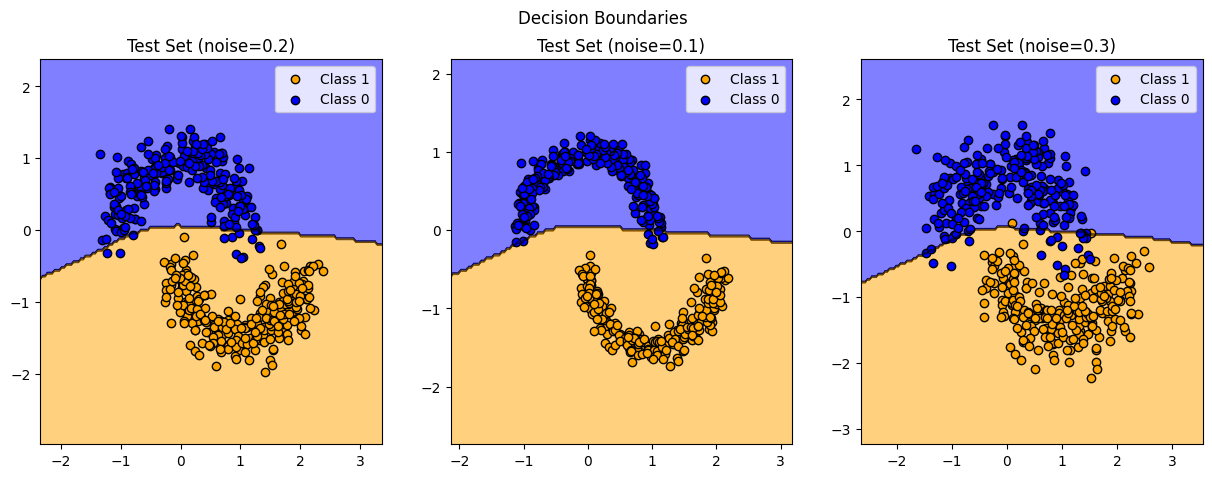

In [26]:
# create fig and axes as i want to plot some images using for loop side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Decision Boundaries")

start = 1

for ax , title in zip(axes, ["Test Set (noise=0.2)", "Test Set (noise=0.1)", "Test Set (noise=0.3)"]):
    if start == 1:
        
        plot_decision_boundary(X_test,y_test,final_mlp_l2,device,ax=ax )

    elif start == 2:
        plot_decision_boundary(X_test_low_noise,y_test_low_noise,final_mlp_l2,device,ax=ax )
    else:
        plot_decision_boundary(X_test_high_noise,y_test_high_noise,final_mlp_l2,device,ax=ax )
    start += 1
    ax.set_title(title)
plt.show()

In [27]:
# --- Step 1: Define Linear Model ---
class LinearClassifier(nn.Module):
    def __init__(self, input_dim=2, output_dim=2):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)  

In [28]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


poly = PolynomialFeatures(degree=5, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_val_poly   = poly.transform(X_val)
X_test_poly = poly.transform(standardize(X_test))  # noise=0.2
X_test_poly_low_noise = poly.transform(X_test_low_noise)  # noise=0.1
X_test_poly_high_noise = poly.transform(X_test_high_noise)  # noise=0.3

scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)

X_val_poly   = scaler.transform(X_val_poly)

X_test_poly = scaler.transform(X_test_poly)

X_test_poly_low_noise = scaler.transform(X_test_poly_low_noise)

X_test_poly_high_noise = scaler.transform(X_test_poly_high_noise)


In [29]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_poly, y_train)

LogisticRegression(max_iter=1000)

In [30]:
y_val_prob = clf.predict_proba(X_val_poly)[:, 1]
val_auc = roc_auc_score(y_val, y_val_prob)
val_acc = accuracy_score(y_val, clf.predict(X_val_poly))

print(f"Validation AUROC: {val_auc:.4f} | Accuracy: {val_acc:.4f}")

Validation AUROC: 1.0000 | Accuracy: 0.9900


In [31]:
for noise_level, X_test_poly, y_test in [
    (0.1, X_test_poly_low_noise, y_test_low_noise),
    (0.2, X_test_poly, y_test),
    (0.3, X_test_poly_high_noise, y_test_high_noise)
]:
    y_test_prob = clf.predict_proba(X_test_poly)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_prob)
    test_acc = accuracy_score(y_test, clf.predict(X_test_poly))
    print(f"Noise={noise_level} | Test AUROC={test_auc:.4f} | Accuracy={test_acc:.4f}")

Noise=0.1 | Test AUROC=1.0000 | Accuracy=0.9720
Noise=0.2 | Test AUROC=1.0000 | Accuracy=0.9960
Noise=0.3 | Test AUROC=0.9955 | Accuracy=0.9440


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import PolynomialFeatures

def plot_decision_boundary_sklearn(X, y, model, poly=False, degree=6, title="Decision Boundary", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.04),
                         np.arange(y_min, y_max, 0.04))
    grid = np.c_[xx.ravel(), yy.ravel()]

    if poly:
        grid = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(grid)

    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['#4DAF4A', '#E41A1C']))
    ax.contour(xx, yy, Z, colors='black', linewidths=0.2)

    # --- Plot data points ---
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='#4DAF4A', marker='o', edgecolors='k', label='Class 0')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='#E41A1C', marker='o', edgecolors='k', label='Class 1')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.set_title(title)
    ax.legend()
   
 


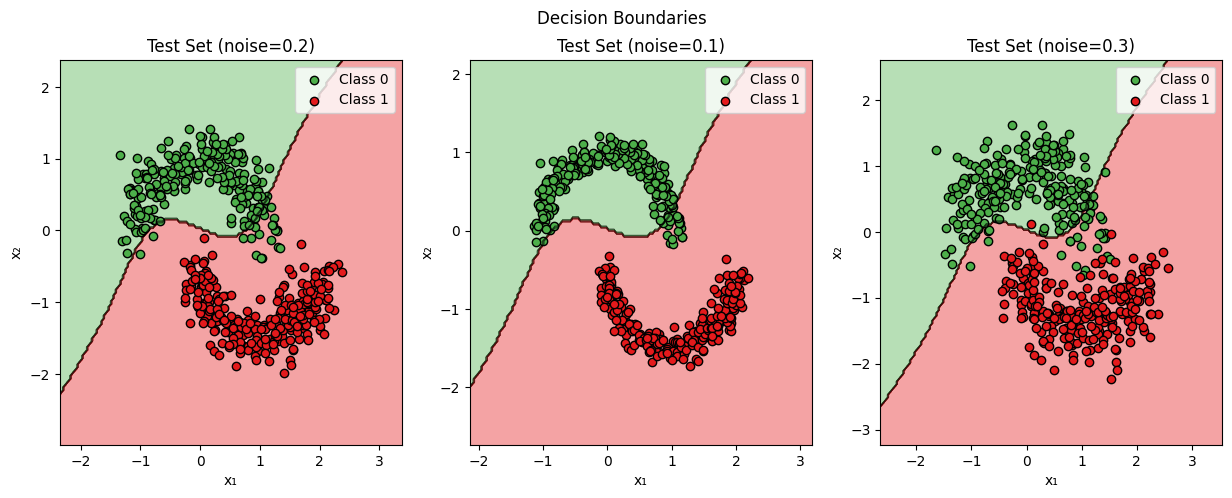

In [33]:


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Decision Boundaries")

start = 1


for ax , title in zip(axes, ["Test Set (noise=0.2)", "Test Set (noise=0.1)", "Test Set (noise=0.3)"]):
    if start == 1:
        plot_decision_boundary_sklearn(X_test, y_test, clf, poly=True, degree=5, title="Decision Boundary (Polynomial Features with Logistic Regression) noise=0.2", ax=ax)
    elif start == 2:
        plot_decision_boundary_sklearn(X_test_low_noise, y_test_low_noise, clf, poly=True, degree=5, title="Decision Boundary (Polynomial Features with Logistic Regression) noise=0.1", ax=ax)
    else:
        plot_decision_boundary_sklearn(X_test_high_noise, y_test_high_noise, clf, poly=True, degree=5, title="Decision Boundary (Polynomial Features with Logistic Regression) noise=0.3", ax=ax)
    start += 1
    ax.set_title(title)
plt.show()

In [34]:
# Create a table with test accuracy for the four models on the three test noise levels. Include parameter count.
results_summary = pd.DataFrame({
    "Model": [
        "MLP without Regularization",
        "MLP with L1 Regularization",
        "MLP with L2 Regularization",
        "Logistic Regression with Polynomial Features"
    ],
    "Test Set (noise=0.2) Accuracy": [
        results_df["Accuracy"][0],
        results_df_regularization["Accuracy"][0],
        results_df_regularization_l2["Accuracy"][0],
        accuracy_score(y_test, clf.predict(X_test_poly))
    ],
    "Test Set (noise=0.1) Accuracy": [
        results_df["Accuracy"][1],
        results_df_regularization["Accuracy"][1],
        results_df_regularization_l2["Accuracy"][1],
        accuracy_score(y_test_low_noise, clf.predict(X_test_poly_low_noise))
    ],
    "Test Set (noise=0.3) Accuracy": [
        results_df["Accuracy"][2],
        results_df_regularization["Accuracy"][2],
        results_df_regularization_l2["Accuracy"][2],
        accuracy_score(y_test_high_noise, clf.predict(X_test_poly_high_noise))
    ],
    "Parameter Count": [
        sum(p.numel() for p in mlp_model_without_regularization.parameters()),
        sum(p.numel() for p in final_mlp_l1.parameters()),
        sum(p.numel() for p in final_mlp_l2.parameters()),
        len(clf.coef_.ravel()) + len(clf.intercept_)
    ]
})
results_summary

,Model,Test Set (noise=0.2) Accuracy,Test Set (noise=0.1) Accuracy,Test Set (noise=0.3) Accuracy,Parameter Count
0,MLP without Regularization,0.998,1.000,0.978,162
1,MLP with L1 Regularization,0.990,0.998,0.974,162
2,MLP with L2 Regularization,0.990,1.000,0.978,162
3,Logistic Regression with Polynomial Features,0.944,0.972,0.944,21


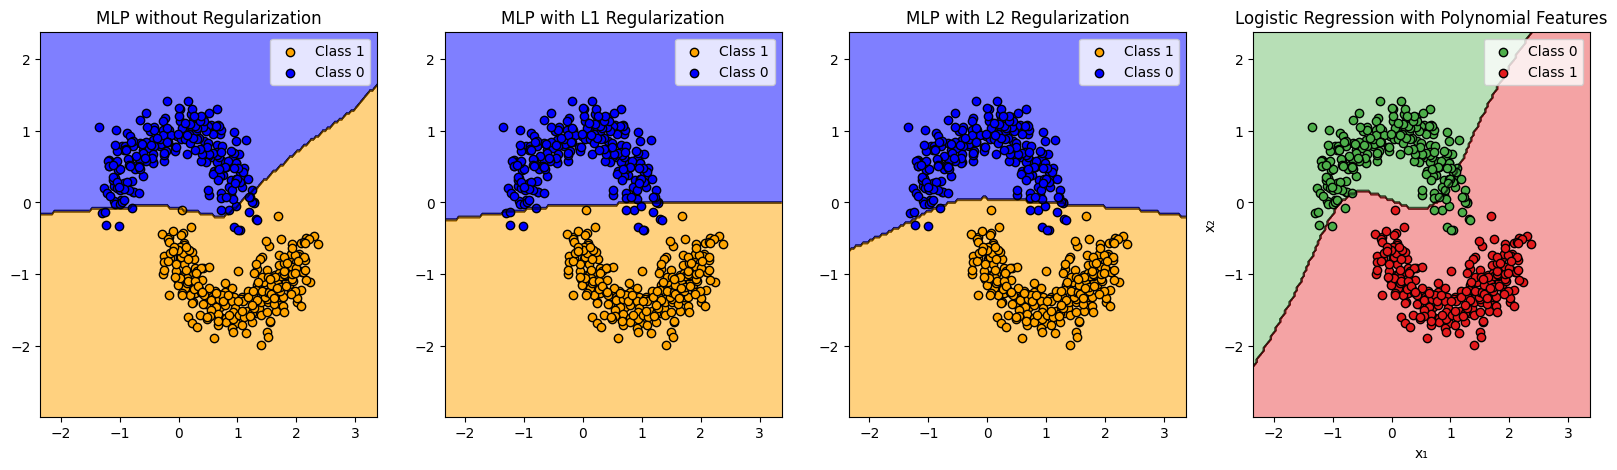

In [35]:
start = 1
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

for ax, title in zip(
    axes,
    ["MLP without Regularization", 
     "MLP with L1 Regularization", 
     "MLP with L2 Regularization", 
     "Logistic Regression with Polynomial Features"]
):
    if start == 1:
        plot_decision_boundary(X_test, y_test, mlp_model_without_regularization, device, ax)
    elif start == 2:
        plot_decision_boundary(X_test, y_test, final_mlp_l1, device, ax)
    elif start == 3:
        plot_decision_boundary(X_test, y_test, final_mlp_l2, device, ax)
    else:
        plot_decision_boundary_sklearn(
            X_test, y_test, clf, poly=True, degree=5,
            title="Decision Boundary (Polynomial Features with Logistic Regression)", ax=ax
        )
    ax.set_title(title)
    start += 1


plt.show()



The figure above shows the decision boundaries learned by MLP models trained on the *Make Moons* dataset with different regularization techniques.

### Effect of L1 Regularization
- **Sparsity:**  
  L1 regularization encourages **sparse weights** by driving many parameters exactly to zero. This means the model learns using only the most important features or neurons, effectively pruning unnecessary connections.
- **Boundary jaggedness:**  
  Because of the sparsity, the resulting decision boundary can appear slightly **more jagged** or **piecewise**, as fewer parameters are actively contributing to the decision function.  
  This makes the boundary simpler but potentially less smooth, reflecting the model’s selective use of weights.

### Effect of L2 Regularization
- **Smoothness:**  
  L2 regularization penalizes large weights more heavily but does **not force them to zero**. Instead, it encourages small, evenly distributed weights, resulting in a **smoother, more stable decision boundary**.
- **Margin:**  
  The L2-regularized model tends to create **larger, smoother margins** between classes. It avoids abrupt changes in predictions and generalizes better to unseen data by preventing overly sharp boundaries.

### Summary
- **L1** → Increases sparsity, leads to simpler but sometimes jagged decision boundaries.  
- **L2** → Produces smoother boundaries and better generalization with larger margins.  

Together, these effects highlight how regularization controls the **complexity** and **shape** of the learned decision surface.


In [36]:
import numpy as np
from sklearn.utils import resample

# Assume you already have X_train, y_train, X_test, y_test
np.random.seed(1337)

train_data = np.column_stack((X_train, y_train))

# Separate each class
class_0 = train_data[train_data[:, -1] == 0]
class_1 = train_data[train_data[:, -1] == 1]

# Desired ratio
ratio_class0 = 0.7
ratio_class1 = 0.3

# Keep total samples same as original
n_total = len(train_data)
n_class0 = int(n_total * ratio_class0)
n_class1 = n_total - n_class0  # ensures sum = total

class_0_new = resample(class_0, replace=True, n_samples=n_class0, random_state=1337)
class_1_new = resample(class_1, replace=True, n_samples=n_class1, random_state=1337)

# Combine and shuffle
imbal_train = np.vstack((class_0_new, class_1_new))
np.random.shuffle(imbal_train)

# Split back into X and y
X_train_imbal = imbal_train[:, :-1]
y_train_imbal = imbal_train[:, -1].astype(int)

n0, n1 = np.sum(y_train_imbal == 0), np.sum(y_train_imbal == 1)
print(f"Class 0 samples: {n0}, Class 1 samples: {n1}")
print(f"Ratio: {n0 / (n0 + n1):.2f}:{n1 / (n0 + n1):.2f}")


Class 0 samples: 280, Class 1 samples: 120
Ratio: 0.70:0.30


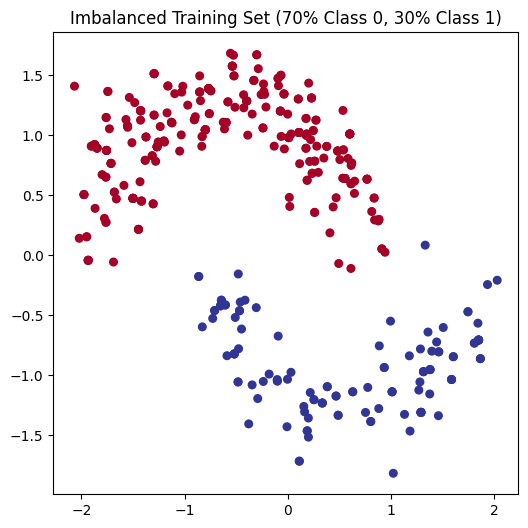

In [37]:
plt.figure(figsize=(6, 6))
plt.scatter(X_train_imbal[:, 0], X_train_imbal[:, 1], c=y_train_imbal, cmap=plt.cm.RdYlBu, s=30)
plt.title("Imbalanced Training Set (70% Class 0, 30% Class 1)")
plt.show()

In [38]:
X_train_imbal, X_val_imbal, y_train_imbal, y_val_imbal = train_test_split(
    X_train_imbal, y_train_imbal, test_size=0.2, random_state=1337, stratify=y_train_imbal
)

mean = X_train_imbal.mean(axis=0)
std = X_train_imbal.std(axis=0)

print("Mean:", mean)
print("Std:", std)

def standardize(X):
    return (X - mean) / std

X_train_imbal = standardize(X_train_imbal)
X_val_imbal = standardize(X_val_imbal)

Mean: [-0.22554379  0.37398976]
Std: [1.01920202 0.94014248]


In [39]:
train_dataset_imbal = TensorDataset(torch.tensor(X_train_imbal, dtype=torch.float32), torch.tensor(y_train_imbal, dtype=torch.long))
val_dataset_imbal = TensorDataset(torch.tensor(X_val_imbal, dtype=torch.float32), torch.tensor(y_val_imbal, dtype=torch.long))
train_loader_imbal = DataLoader(train_dataset_imbal, batch_size=32, shuffle=True)
val_loader_imbal = DataLoader(val_dataset_imbal, batch_size=32, shuffle=False)


In [40]:
mlp_model_imbal = MLP().to(device)
optimizer = torch.optim.Adam(mlp_model_imbal.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [41]:
best_val_acc_imbal, train_losses_imbal, val_losses_imbal = train_model(mlp_model_imbal, train_loader, val_loader, criterion, optimizer, device, None, 0.0, 100, 50)

Epoch 1/100 | Train Loss: 0.6020 | Val Acc: 0.9100 | Val Loss: 0.4503
Epoch 11/100 | Train Loss: 0.0130 | Val Acc: 0.9900 | Val Loss: 0.0428
Epoch 21/100 | Train Loss: 0.0052 | Val Acc: 0.9900 | Val Loss: 0.0574
Epoch 31/100 | Train Loss: 0.0026 | Val Acc: 0.9900 | Val Loss: 0.0644
Epoch 41/100 | Train Loss: 0.0016 | Val Acc: 0.9900 | Val Loss: 0.0756
Epoch 51/100 | Train Loss: 0.0010 | Val Acc: 0.9900 | Val Loss: 0.0775
Early stopping at epoch 54


In [46]:
test_results_imbal = evaluate_model(mlp_model_imbal, test_loader, criterion=criterion, device=device, compute_auroc=True)

test_results_imbal_low_noise = evaluate_model(mlp_model_imbal, test_loader_low_noise, criterion=criterion, device=device, compute_auroc=True)

test_results_imbal_high_noise = evaluate_model(mlp_model_imbal, test_loader_high_noise, criterion=criterion, device=device, compute_auroc=True)


results_df_imbal = pd.DataFrame({
    "Dataset": ["Test Set (noise=0.2)", "Test Set (noise=0.0)", "Test Set (noise=0.4)"],
    "Accuracy": [test_results_imbal["accuracy"], test_results_imbal_low_noise["accuracy"], test_results_imbal_high_noise["accuracy"]],
    "Loss" : [test_results_imbal["loss"], test_results_imbal_low_noise["loss"], test_results_imbal_high_noise["loss"]],
    "AUROC": [test_results_imbal["auroc"], test_results_imbal_low_noise["auroc"], test_results_imbal_high_noise["auroc"]],
})



results_df_imbal


,Dataset,Accuracy,Loss,AUROC
0,Test Set (noise=0.2),0.998,0.016657,0.999712
1,Test Set (noise=0.0),1.000,0.000396,1.000000
2,Test Set (noise=0.4),0.978,0.074523,0.998192


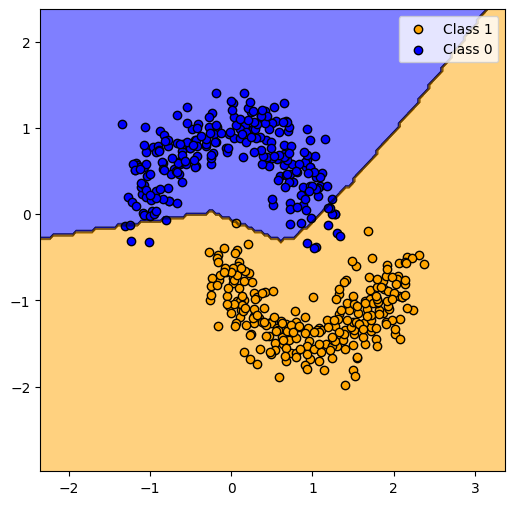

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

plot_decision_boundary(X_test, y_test, mlp_model_imbal, device, ax)

plt.show()

## Effect of Class Imbalance on Model Performance

In this experiment, the training dataset was made **imbalanced (70:30)** while keeping the **test set balanced**, to study the impact of imbalance on model performance.  
The model was then evaluated on test sets with different noise levels.

| Dataset | Accuracy | Loss | AUROC |
|----------|-----------|------|--------|
| Test Set (noise = 0.2) | 0.998 | 0.0167 | 0.9997 |
| Test Set (noise = 0.0) | 1.000 | 0.0004 | 1.0000 |
| Test Set (noise = 0.4) | 0.978 | 0.0745 | 0.9982 |

### Observations
- **High overall performance:**  
  The model maintains high accuracy and AUROC across all test sets, suggesting that the learned decision boundary remains effective even when trained on imbalanced data.
- **Effect of imbalance:**  
  Since AUROC remains close to 1.0, the model still ranks positive and negative samples very well, showing that the imbalance did not severely affect its discriminative ability.  
  However, slight variations in accuracy across different noise levels indicate that **imbalanced training can make the model slightly biased toward the majority class**, which becomes more noticeable when noise increases.
- **Noise sensitivity:**  
  As the noise level rises (e.g., 0.4), both accuracy and AUROC decrease slightly — showing that noise amplifies the negative effects of imbalance, making it harder for the model to correctly classify minority samples.

### Conclusion
The results indicate that while the model is robust and maintains high AUROC even under imbalance, class imbalance can subtly reduce its ability to generalize, especially under noisy conditions.  
AUROC remains a reliable metric here, as it reflects the model’s overall separability independent of class proportions.
